In [1]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods
import glob
from tqdm.auto import tqdm

from utils import set_plotting_style, numba_histogram, numba_histogram2d, make_profile

In [2]:
set_plotting_style()

In [3]:
%%time
t = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau5mm_skim2mu.root")["Events"]
cache = uproot.ArrayCache("16GB")
readkw = dict(cache=cache,entrystop=10000000)

CPU times: user 78 ms, sys: 5 ms, total: 83 ms
Wall time: 878 ms


In [4]:
tlead = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("LeadingPair_*",outputtype=dict,namedecode="ascii").items()})
tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
tpv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("PVM_*",outputtype=dict,namedecode="ascii").items()})
tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii").items()})

tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
tdv["rho"] = np.hypot(tdv.x,tdv.y)
tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

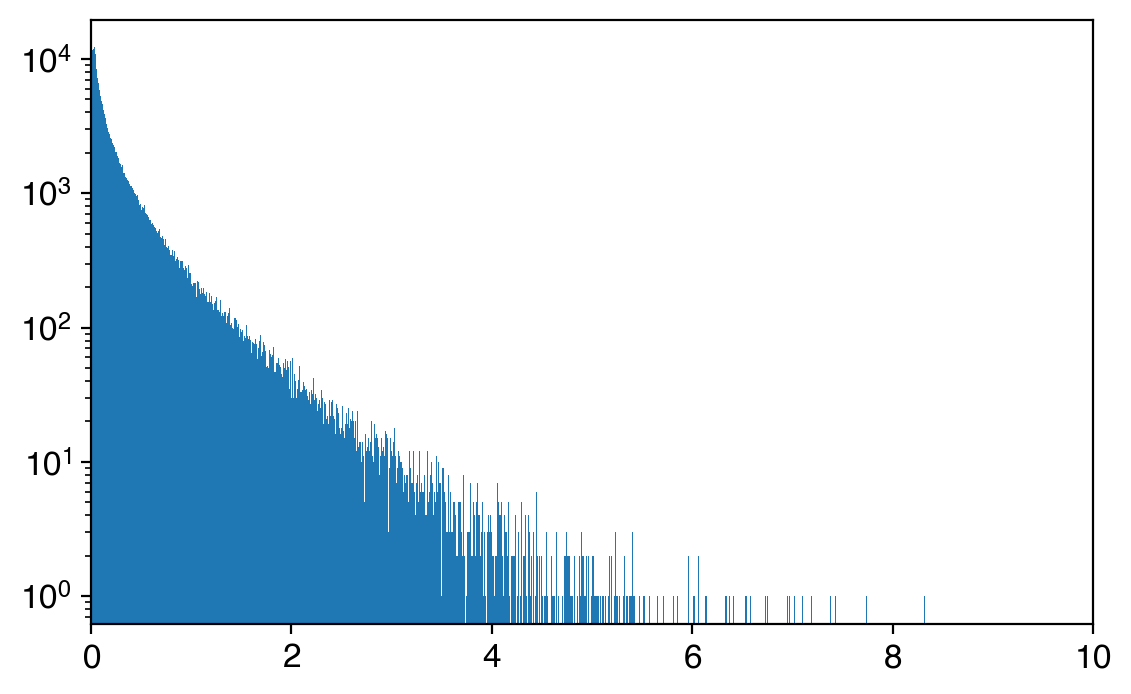

In [5]:
fig,ax = plt.subplots()
_ = ax.hist(np.abs(tmu.dxy.flatten()),bins=np.linspace(0,10,1000));
ax.set_yscale("log")

CPU times: user 1.39 s, sys: 4.17 s, total: 5.57 s
Wall time: 3.11 s


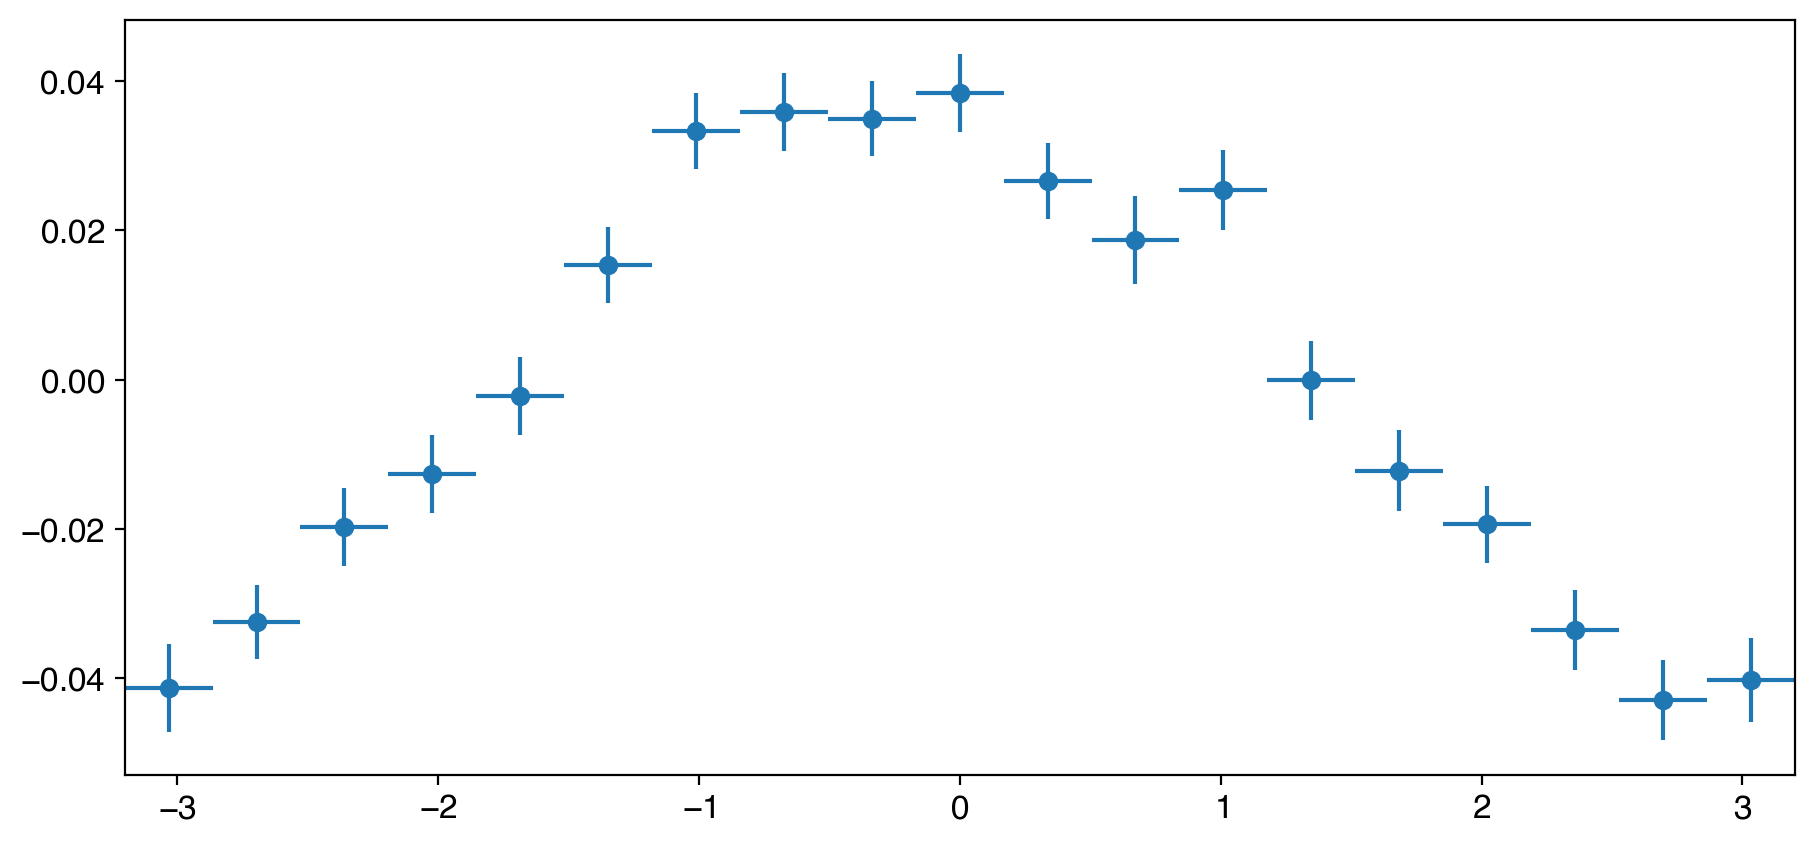

In [6]:
%%time
edges = np.linspace(-3.2,3.2,20)
y,yerr = make_profile(tobin=tmu.phi.flatten(),toreduce=tmu.dxy.flatten(),edges=edges)
# from scipy.stats import binned_statistic
# # edges = np.logspace(0.,1.5,200)
# edges = np.linspace(0.0,20.,200)
# yvals = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'mean', bins=edges).statistic
# yerr = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'std', bins=edges).statistic/(binned_statistic(rho, costheta, 'count', bins=edges).statistic**0.5)
fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o')
# ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# ax.set_xscale("log")
# ax.set_ylabel(r"Mean cos$\theta$")
# ax.set_xlabel("DV rho")

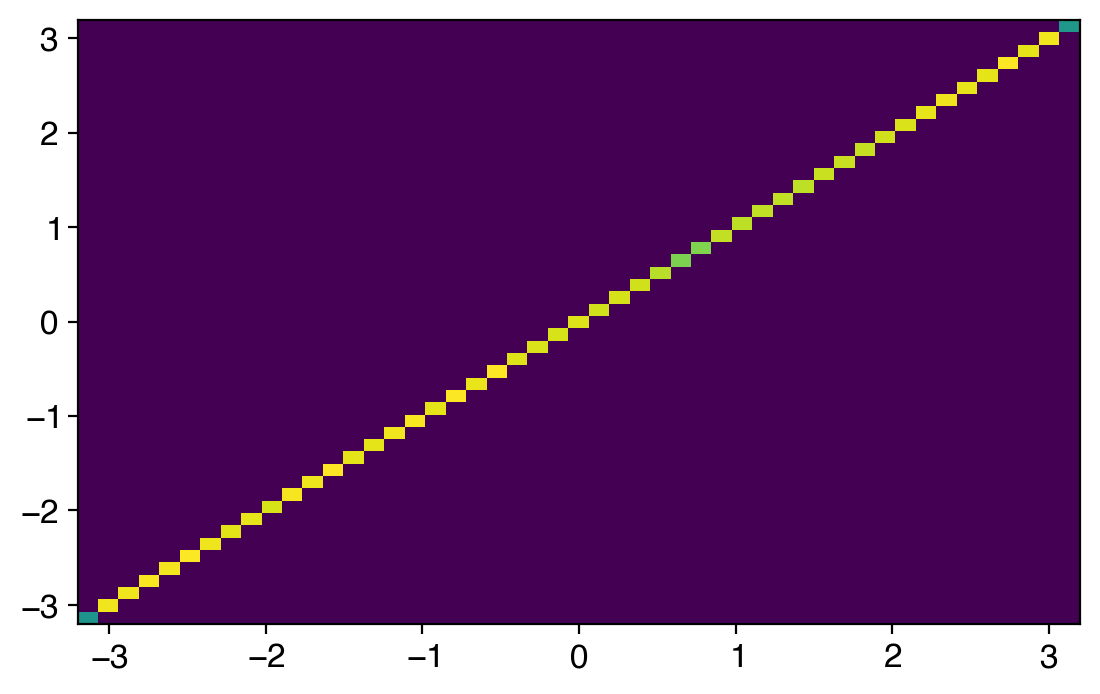

In [14]:
# tmu.phi.flatten(),toreduce=tmu.dxy.flatten(),edges=edges)
fig,ax = plt.subplots()
bins = [np.linspace(-3.2,3.2,50),np.linspace(-3.2,3.2,50)]
ax.hist2d(tmu.trk_phi.flatten(),tmu.phi.flatten(),bins=bins);

In [15]:
# https://github.com/cms-sw/cmssw/blob/master/DataFormats/TrackReco/interface/TrackBase.h#L24
def calc_dxy(x,y,phi):
    return -x*np.sin(phi) + y*np.cos(phi)
mydxy = calc_dxy(tdv.x[:,0],tdv.y[:,0],tmu.phi)

In [16]:
tmu.dxy

<JaggedArray [[0.02479314 0.17786498] [0.058187086 -0.21494226] [-0.3931198 0.5270012] ... [0.06151726 -0.13266003] [-0.015178304 0.045547277] [0.7707246 -1.5851322]] at 0x7f2d444ddc18>

In [17]:
print(tdv.y.shape)
print(tmu.phi.shape)

(99887,)
(99887,)


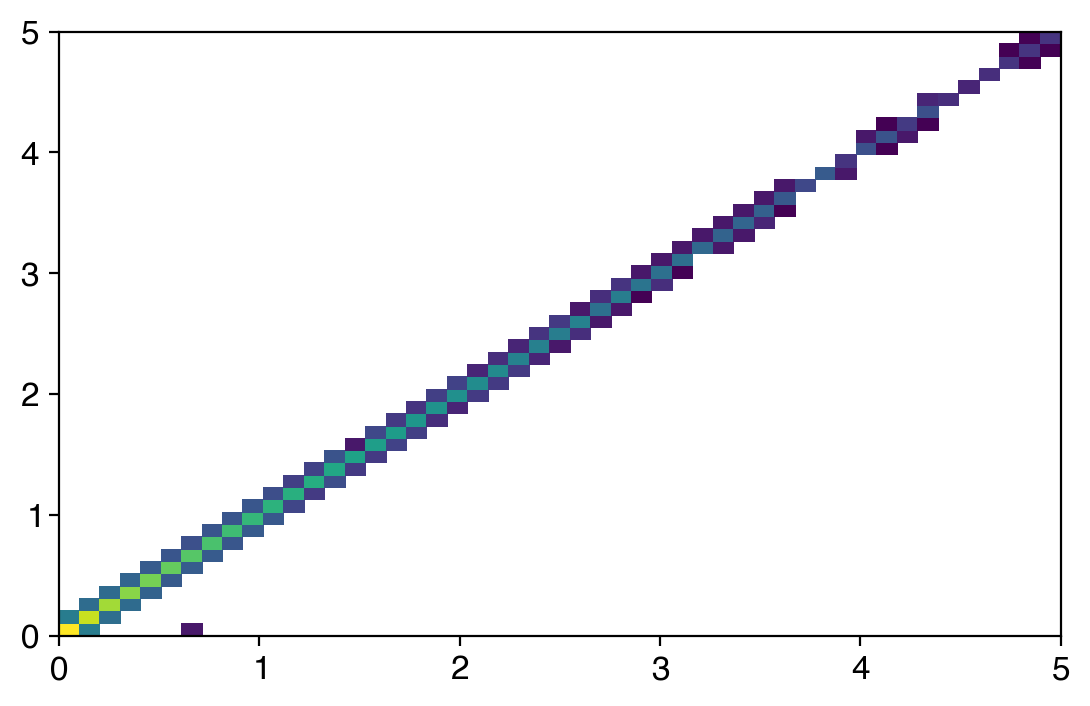

In [18]:
fig,ax = plt.subplots()
bins = [np.linspace(0,5,50),np.linspace(0,5,50)]
# ax.hist2d(mydxy.flatten(),tmu.dxy.flatten(),bins=bins,norm=LogNorm());
# sel = (tdv.x.counts >= 2) & (tmu.dxy.counts >= 3)
sel = (tdv.x.counts == 1) & (tmu.dxy.counts == 2)
ax.hist2d(mydxy[sel].flatten(),tmu.dxy[sel].flatten(),bins=bins,norm=LogNorm());

In [19]:
# (mydxy[sel].flatten()-tmu.dxy[sel].flatten()).mean()
(mydxy[sel].flatten()-tmu.dxy[sel].flatten()).std()

0.013739595

In [20]:
# Events->Scan("recoBeamSpot_offlineBeamSpot__RECO.obj.x0()") in miniaod (and y0)
# https://github.com/cms-sw/cmssw/blob/master/DataFormats/BeamSpot/interface/BeamSpot.h
bsx = 0.0107796
bsy = 0.041893

In [21]:
print(tpv.x[:,0].mean())
print(tpv.y[:,0].mean())

print(tpv.x[:,0].mean()-bsx)
print(tpv.y[:,0].mean()-bsy)

0.010777747
0.04189386
-1.852741456032092e-06
8.584625720980954e-07


CPU times: user 165 ms, sys: 2 ms, total: 167 ms
Wall time: 165 ms


Text(0, 0.5, 'mean dxy')

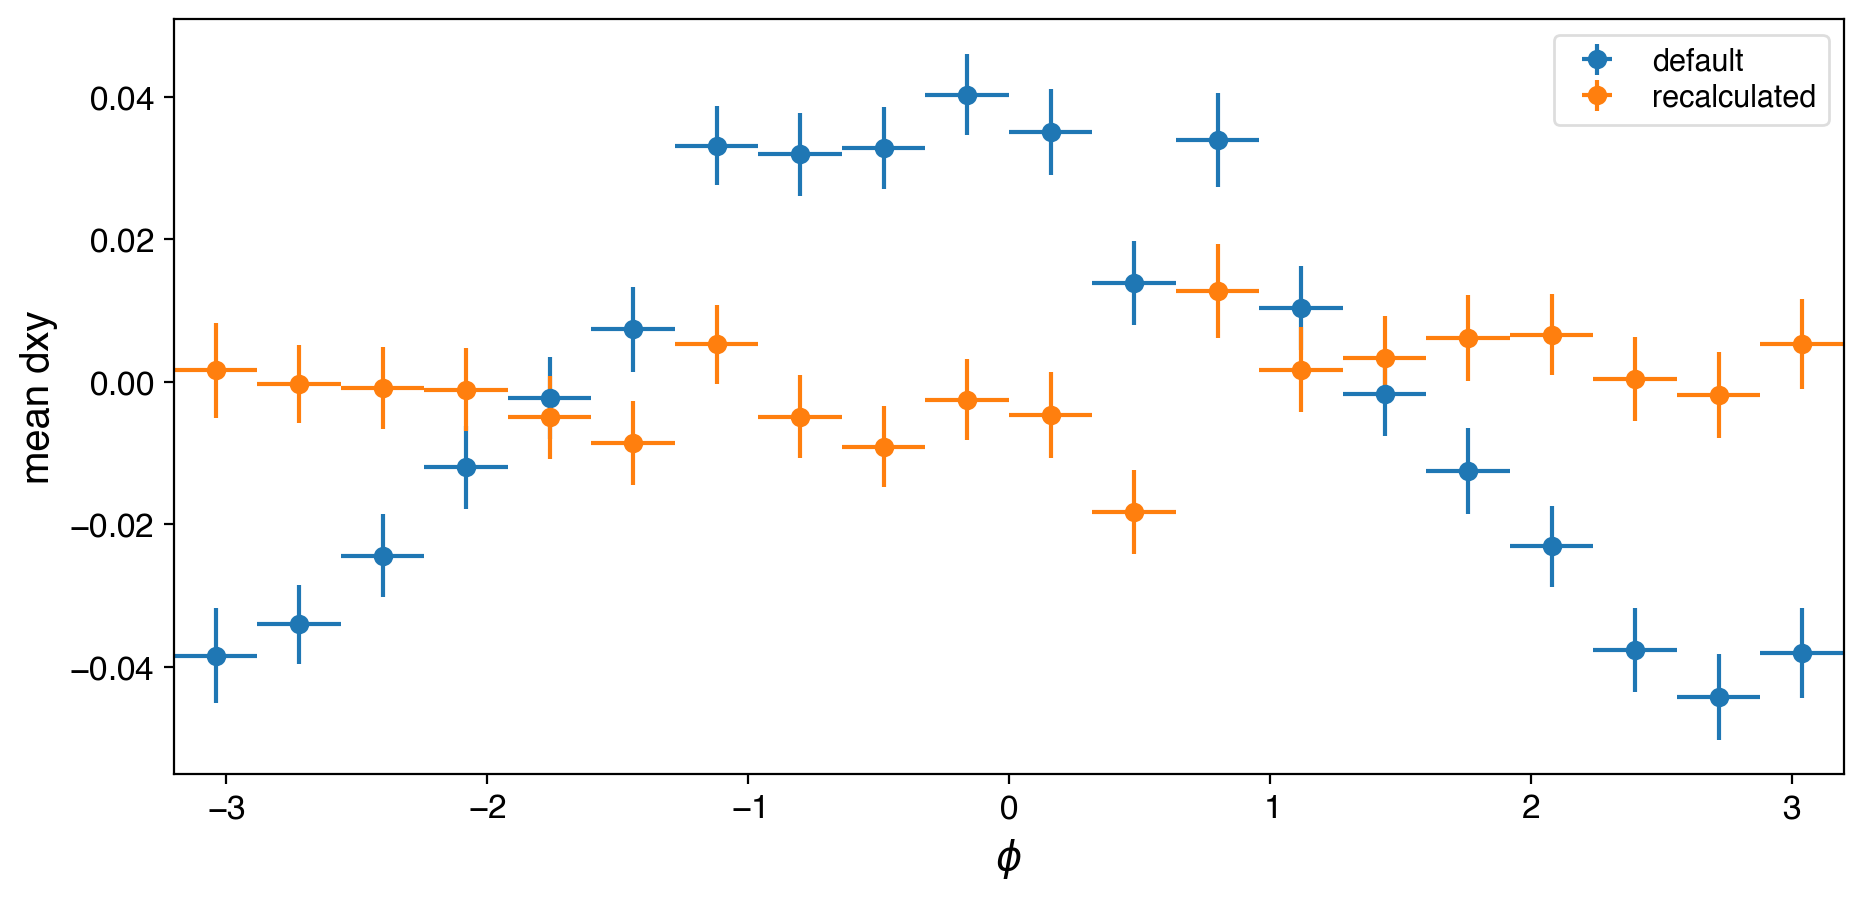

In [24]:

%%time
edges = np.linspace(-3.2,3.2,21)
sel = (tdv.x.counts == 1) & (tmu.dxy.counts == 2)

fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=tmu.dxy[sel].flatten(),edges=edges)
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="default")

# mydxy = calc_dxy(tdv.x[:,0]-tpv.x.flatten().mean(),tdv.y[:,0]-tpv.y.flatten().mean(),tmu.phi)
# y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
# _ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="mine3")

# mydxy = calc_dxy(tdv.x[:,0]-tpv.x[:,0],tdv.y[:,0]-tpv.y[:,0],tmu.phi)
# y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
# _ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="mine2")

mydxy = calc_dxy(tdv.x[:,0]-bsx,tdv.y[:,0]-bsy,tmu.phi)
y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="recalculated")

ax.legend()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"mean dxy")

In [25]:
dfbs = pd.concat(map(pd.read_csv,tqdm(glob.glob("/home/users/namin/2019/scouting/repo/beamspot/outputs/*.csv"))))
dfbs

,x,y,z,run,lumi
0,0.095462,-0.065060,-0.594701,319658,5
1,0.095480,-0.065028,-0.409183,319657,155
2,0.095480,-0.065028,-0.409183,319657,161
3,0.095470,-0.065023,-0.649757,319639,586
4,0.095462,-0.065060,-0.594701,319658,10
...,...,...,...,...,...
42,0.095631,-0.063334,-0.251168,320008,70
43,0.095625,-0.063339,-0.469348,320008,27
44,0.095777,-0.063741,-0.263219,319993,579
45,0.095589,-0.063330,-0.488202,320006,65


In [75]:
for i in range(1,15):
    t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_{}.root".format(i))["Events"]
    run = t["run"].array(**readkw)
    lumi = t["luminosityBlock"].array(**readkw)
    df = pd.DataFrame(dict(run=run,lumi=lumi))
    before = df.shape[0]
    df = df.merge(dfbs,how="left",on=["run","lumi"])
    df = df.dropna()
    after = df.shape[0]
    print(i,before,after,before==after)

1 5906367 5906367 True
2 3989920 3989920 True
3 4986627 4986627 True
4 3852088 3852088 True
5 4414875 4414875 True
6 4028885 4028885 True
7 5413936 5413936 True
8 5356967 5356967 True
9 4209121 4209121 True
10 3915173 3915173 True
11 4185899 4185899 True
12 4389775 4389775 True
13 5161198 5161198 True
14 4612615 4612615 True


0.0956230852904014 -0.06411399255389924 1.732817314716829 75.10381694141837


(-0.07, -0.06)

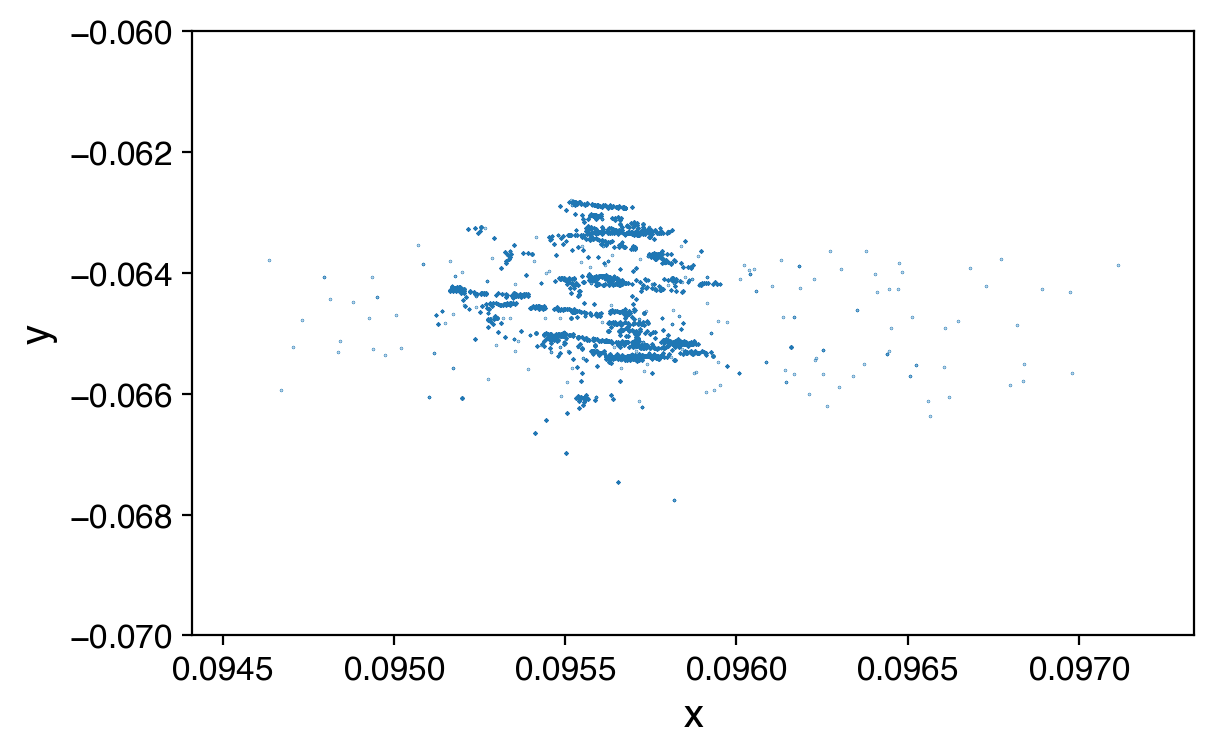

In [41]:
print(
    dfbs.x.mean(),
    dfbs.y.mean(),
    dfbs.x.std()*1e4,
    dfbs.y.std()*1e4,
)
fig, ax = plt.subplots()
dfbs.plot.scatter(x="x",y="y",s=0.05,ax=ax)
ax.set_ylim([-0.070,-0.060])

In [42]:

# t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_1.root")["Events"]
t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_2.root")["Events"]

In [44]:
t.array("PVM_x")

<JaggedArray [[0.0960151 0.096037716 0.09611392 0.096176445] [0.09560048 0.09575986 0.09547447 0.095677145] [0.0958864 0.09590626 0.09596199 ... 0.09574806 0.09603651 0.096051574] ... [0.095776804] [0.09572643] [0.09591797 0.09573706 0.095944144]] at 0x7f2cb8dc82b0>

In [ ]:
# tdv[:,0]

In [42]:
%%time
run = t["run"].array(**readkw)
lumi = t["luminosityBlock"].array(**readkw)

CPU times: user 150 ms, sys: 21 ms, total: 171 ms
Wall time: 1.29 s


In [43]:
%%time
df = pd.DataFrame(dict(run=run,lumi=lumi))
df

CPU times: user 2 ms, sys: 71 ms, total: 73 ms
Wall time: 73.2 ms


,run,lumi
0,319579,2797
1,319579,2797
2,319579,2797
3,319579,2797
4,319579,2797
...,...,...
3989915,319579,3170
3989916,319579,3170
3989917,319579,3170
3989918,319579,3170


In [44]:
df = df.merge(dfbs,how="left",on=["run","lumi"])

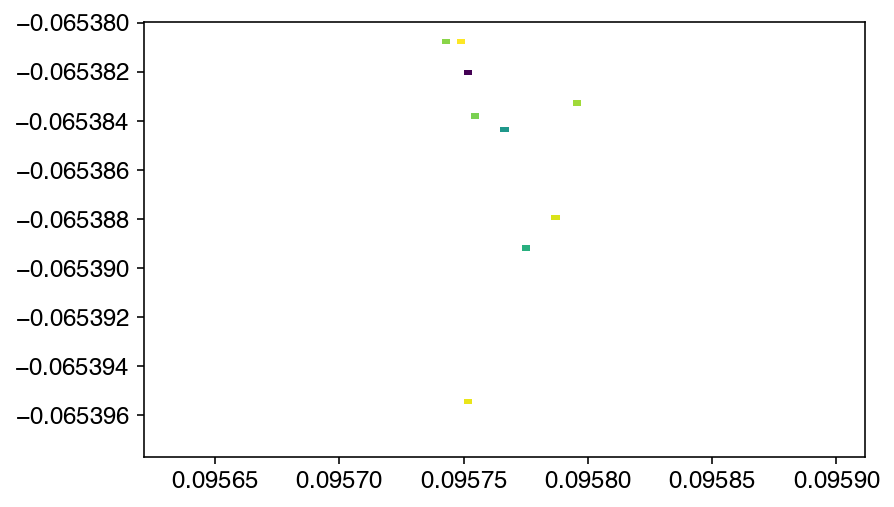

In [45]:
# _ = plt.hist2d(df.x,df.y,bins=[100,100],norm=LogNorm());
xm = df.x.mean()
xs = df.x.std()
ym = df.y.mean()
ys = df.y.std()
# _ = plt.hist2d(df.x,df.y,bins=[np.linspace(0.095,0.096,100),np.linspace(-0.08,-0.05,100)],norm=LogNorm());
_ = plt.hist2d(df.x,df.y,bins=[np.linspace(xm-5*xs,xm+5*xs,100),np.linspace(ym-0.5*ys,ym+0.5*ys,100)],norm=LogNorm());

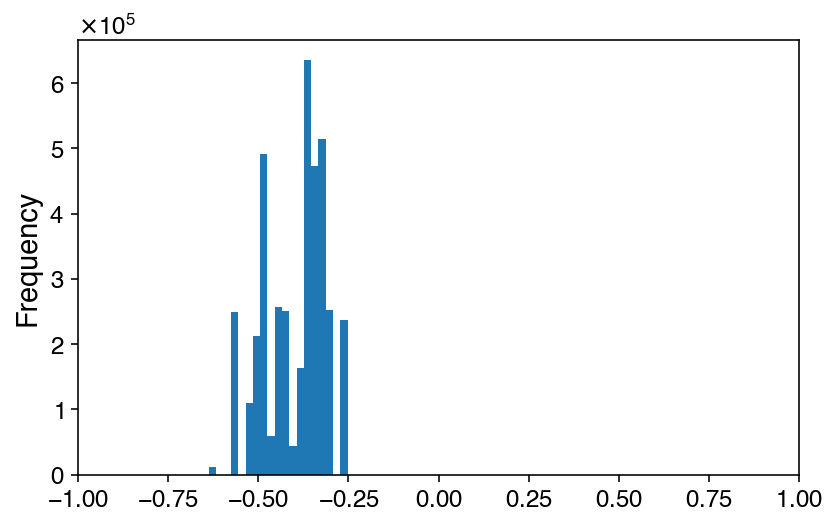

In [50]:
df.z.plot.hist(bins=np.linspace(-1,1,100))

In [60]:
dfbs.set_index(["run","lumi"]).to_dict()

{'x': {(319658, 5): 0.09546180785049999,
  (319657, 155): 0.0954800369025,
  (319657, 161): 0.0954800369025,
  (319639, 586): 0.0954695089733,
  (319658, 10): 0.09546180785049999,
  (319658, 16): 0.09546180785049999,
  (319756, 1241): 0.09547699599300001,
  (319658, 25): 0.09546678749289998,
  (319756, 1285): 0.0954405210699,
  (319658, 14): 0.09546180785049999,
  (319657, 158): 0.0954800369025,
  (319656, 274): 0.0954449940261,
  (319639, 666): 0.09553725827130001,
  (319756, 1245): 0.09547699599300001,
  (319657, 147): 0.09545868597010002,
  (319756, 1238): 0.09547699599300001,
  (319657, 140): 0.09545868597010002,
  (319657, 154): 0.0954800369025,
  (319657, 160): 0.0954800369025,
  (319658, 11): 0.09546180785049999,
  (319657, 136): 0.09545868597010002,
  (319658, 6): 0.09546180785049999,
  (319657, 150): 0.0954800369025,
  (319678, 93): 0.0953232522909,
  (319658, 143): 0.09547810178649999,
  (319657, 157): 0.0954800369025,
  (319756, 580): 0.0953555460149,
  (319756, 1239): 0.095

In [65]:
dfbs["xyz"] = list(dfbs[["x","y","z"]].itertuples(index=False,name=None))

In [72]:
bstable = dfbs.set_index(["run","lumi"])["xyz"].to_dict()

In [73]:
bstable

{(319658, 5): (0.09546180785049999, -0.0650600892311, -0.5947005280259999),
 (319657, 155): (0.0954800369025, -0.0650278948428, -0.40918276041),
 (319657, 161): (0.0954800369025, -0.0650278948428, -0.40918276041),
 (319639, 586): (0.0954695089733, -0.0650231753715, -0.649756906837),
 (319658, 10): (0.09546180785049999, -0.0650600892311, -0.5947005280259999),
 (319658, 16): (0.09546180785049999, -0.0650600892311, -0.5947005280259999),
 (319756, 1241): (0.09547699599300001, -0.0645704013854, -0.378668588587),
 (319658, 25): (0.09546678749289998, -0.06507160935669999, -0.527046984124),
 (319756, 1285): (0.0954405210699, -0.0645827335617, -0.434178983147),
 (319658, 14): (0.09546180785049999, -0.0650600892311, -0.5947005280259999),
 (319657, 158): (0.0954800369025, -0.0650278948428, -0.40918276041),
 (319656, 274): (0.0954449940261, -0.0649943062317, -0.45708935635700004),
 (319639, 666): (0.09553725827130001, -0.0650778618374, -0.33720664935),
 (319756, 1245): (0.09547699599300001, -0.064